In [64]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
import numpy as np
import sklearn.datasets
#import sklearn.cross_validation
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import ensemble
import time
import pickle
import random
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
import keras 
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from sklearn.preprocessing import OneHotEncoder

from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from keras.layers import RepeatVector
from keras.layers import Permute
from keras.layers import merge
from keras.layers import Lambda
from keras.layers import multiply
from keras.layers import concatenate
import tensorflow as tf

In [3]:
#Test and Train Data
train = pd.read_csv("/Users/s0c02nj/Desktop/DataQuora//train.csv",encoding="utf-8")
test = pd.read_csv("/Users/s0c02nj/Desktop/DataQuora//test.csv",encoding="utf-8")

In [4]:
#Submission File
sub = pd.read_csv('/Users/s0c02nj/Desktop/DataQuora//sample_submission.csv')

In [5]:
test.head()

qid                                      question_text
0  00014894849d00ba98a9  My voice range is A2-C5. My chest voice goes u...
1  000156468431f09b3cae           How much does a tutor earn in Bangalore?
2  000227734433360e1aae  What are the best made pocket knives under $20...
3  0005e06fbe3045bd2a92  Why would they add a hypothetical scenario tha...
4  00068a0f7f41f50fc399   What is the dresscode for Techmahindra freshers?

In [6]:
#Counting the no of zeros and ones
train['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [7]:
#Distribution of words for train 
train_count=[]
for i in train['question_text'] :
    cnt=len(i)
    train_count.append(cnt)

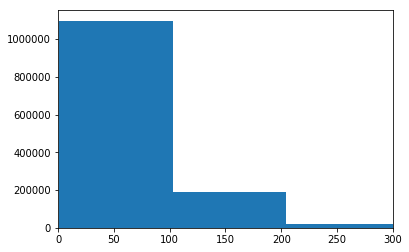

In [8]:
plt.hist(train_count)
plt.xlim(0,300)
plt.show()

In [9]:
#Distribution of words for test 
test_count=[]
for i in test['question_text'] :
    cnt=len(i)
    test_count.append(cnt)

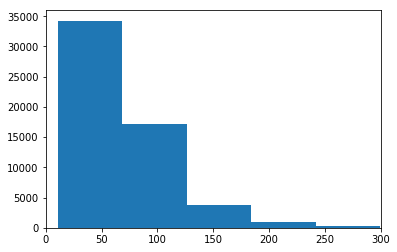

In [10]:
plt.hist(test_count)
plt.xlim(0,300)
plt.show()

### Sentiment Analysis

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [32]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    #print("{:-<40} {}".format(sentence, str(score)))
    return score

In [28]:
a=sentiment_analyzer_scores("Has the United States become the largest dictatorship in the world?")

Has the United States become the largest dictatorship in the world? {'neg': 0.0, 'neu': 0.781, 'pos': 0.219, 'compound': 0.4215}


In [17]:
a

{'neg': 0.0, 'neu': 0.326, 'pos': 0.674, 'compound': 0.7351}

In [91]:
neg=[]
neu=[]
pos=[]
comp=[]
for i in train['question_text'] :
    sent=sentiment_analyzer_scores(i)
    neg.append(sent['neg'])
    neu.append(sent['neu'])
    pos.append(sent['pos'])
    comp.append(sent['compound'])

In [16]:
train['Negative Sentiment']= neg
train['Positive Sentiment']= pos
train['Neutral Sentiment']= neu
train['Compound Sentiment']= comp

In [17]:
neg=np.reshape(neg,(-1,1))
pos=np.reshape(pos,(-1,1))
neu=np.reshape(neu,(-1,1))
comp=np.reshape(comp,(-1,1))

In [18]:
train.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  Negative Sentiment  Positive Sentiment  Neutral Sentiment  \
0       0                 0.0               0.000              1.000   
1       0                 0.0               0.263              0.737   
2       0                 0.0               0.000              1.000   
3       0                 0.0               0.000              1.000   
4       0                 0.0               0.000              1.000   

   Compound Sentiment  
0              0.0000  
1              0.6124  
2              0.0000  
3              0.0000  
4              0.0000

### Sampling Data

In [20]:
train_neg=train[train['target']==0]
train_pos=train[train['target']==1]

In [21]:
train_neg_sample=train_neg[1:245062]
train_sampled = pd.concat((train_neg_sample,train_pos))

In [22]:
train_sampled['target'].value_counts()

0    245061
1     80810
Name: target, dtype: int64

In [23]:
#Tokenizing the text
max_features = 50000
tokenizer = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(test['question_text'].values)
tokenizer.fit_on_texts(full_text)

In [24]:
#Tokenizing the documents---- convert to strings
train_tokenized = tokenizer.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tokenizer.texts_to_sequences(test['question_text'].fillna('missing'))

In [25]:
#Padding the same
max_len = 70
X_train = pad_sequences(train_tokenized, maxlen = max_len,padding='pre')
X_test = pad_sequences(test_tokenized, maxlen = max_len,padding='pre')

In [26]:
ohe = OneHotEncoder(sparse=False)
#y_ohe = ohe.fit_transform(train['target'].values.reshape(-1, 1))
y= keras.utils.to_categorical(train['target'])

In [27]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [28]:
#word_index is dictionary of the words and the sequence
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 462675 unique tokens.


In [29]:
folder_path= '/Users/s0c02nj/Downloads/glove.6B/glove.6B.50d.txt'
f=open(folder_path)
doc=f.readlines()
#****VIP
#**WORD TO VEC DICTIONARY
#Forming a dictionary-word2vec
word2vec={}
key=[]
#looping though the doc.in the doc the entire thing is saved and is separated by a space bar.
for line in doc:
    #parts contains every word separately for doc1
    parts=line.split(' ')
    #part[0] contains the word
    word=parts[0]
    key.append(word)
    #embed contains the vector
    embed=np.array(parts[1:],dtype='float32')
    #filling up the dictionary
    word2vec[word]=embed


In [30]:
#Embedding matrix creation
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, 50))

for word, i in word_index.items():
    #print i
    if i >= nb_words:
        continue
    if word in word2vec:
        embedding_vector = word2vec[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 1


keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', 
                      embeddings_regularizer=None, activity_regularizer=None, 
                      embeddings_constraint=None, mask_zero=False, input_length=None)

input_length: Length of input sequences, when it is constant.

2D tensor with shape: (batch_size, sequence_length).


3D tensor with shape: (batch_size, sequence_length, output_dim).
embedding_matrix.shape

nb_wordsEMBEDDING_DIM

Embedding(vocabulary_size, 50, input_length=200, weights=[embedding_matrix], trainable=True)

In [20]:
# def model_bilstm():
#     inputs = Input(shape=(max_len,))
#     layer =  Embedding(max_features ,50,input_length=max_len,trainable=False,weights = [embedding_matrix])(inputs)
#     layer =  Bidirectional(LSTM(64,return_sequences=False))(layer)
#     layer=   Dense(16, activation="relu")(layer)
#     layer=   Dropout(0.1)(layer)
#     layer =  Dense(2,name='out_layer',activation='sigmoid')(layer)
    
#     model =  Model(inputs=inputs,outputs=layer)
#     return model

shape: A shape tuple (integers), not including the batch size. For instance, shape=(32,) 
indicates that the expected input will be batches of 32-dimensional vectors.

In [31]:
def model_attn_bilstm():
    inputs = Input(shape=(max_len,))
    layer =  Embedding(max_features ,50,input_length=max_len,trainable=False,weights = [embedding_matrix])(inputs)
    layer =  Bidirectional(LSTM(64,return_sequences=True))(layer)
    
    #Attention
    activations_weights = Dense(1, activation='tanh')(layer)
    activations_weights = Flatten()(activations_weights)
    activations_weights = Activation('softmax')(activations_weights)
    activations_weights = RepeatVector(128)(activations_weights)
    activations_weights = Permute([2, 1])(activations_weights)
    activations_weighted = multiply([layer, activations_weights])
    sent_representation = Lambda(lambda x: K.sum(x, axis=-2))(activations_weighted)
    
    #Defining inputs for sentiment scores
    input_neg=Input(shape=(1,))
    input_pos=Input(shape=(1,))
    input_neu=Input(shape=(1,))
    input_comp=Input(shape=(1,))
    
    #Concatenating
    layer_sentiment = concatenate([sent_representation,input_neg,input_pos,input_neu,input_comp],axis=1)
    
    #Dense Layer
    layer_sentiment= Dense(20, activation='tanh')(layer_sentiment)
    
    #Output Layer
    probabilities = Dense(2,activation='softmax')(layer_sentiment)

    model = Model(inputs=[inputs,input_neg,input_pos,input_neu,input_comp],outputs=probabilities)
    return model

In [32]:
model= model_attn_bilstm()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 50)       2500000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 70, 128)      58880       embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 70, 1)        129         bidirectional_1[0][0]            
__________________________________________________________________________________________________
flatten_1 

In [33]:
model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = ["accuracy"])

In [34]:
history = model.fit([X_train,neg,pos,neu,comp] ,y, batch_size = 512, epochs = 2, validation_split=0.1, 
                        verbose = 1)

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 994s 845us/step - loss: 0.1484 - acc: 0.9463 - val_loss: 0.1327 - val_acc: 0.9500
Epoch 2/2
1175509/1175509 [==============================] - 1000s 850us/step - loss: 0.1283 - acc: 0.9517 - val_loss: 0.1264 - val_acc: 0.9520


In [27]:
pred = model.predict(X_test, batch_size = 1024, verbose = 1)

56370/56370 [==============================] - 7s 122us/step


In [32]:
predictions = np.round(np.argmax(pred, axis=1)).astype(int)
sub['prediction'] = predictions
sub.to_csv("/Users/s0c02nj/Desktop/Data/submission.csv", index=False)